In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target
iris_df.head()

dt_clf = DecisionTreeClassifier(random_state=156)

In [2]:
def how_many_label(n_iter, selection, y_min, y_max):
    plt.subplot(3, 2, n_iter)
    bars = plt.bar(['0','1','2'], selection['species'].value_counts().values, color=['r','g','b'])
    for i, b in enumerate(bars):
        plt.text(b.get_x()+b.get_width()*(1/2), b.get_height()+1, 
                selection['species'].value_counts().values[i], ha='center',fontsize=13)
    plt.ylim(y_min, y_max)
    plt.title('{0} Times'.format(n_iter))

# 학습/테스트 데이터 세트 분리 - train_test_split( )
- 학습용 데이터와 테스트 데이터로 분리 -> 총 2개의 데이터로 분리
- 교차 검증 분할 및 평가
- Estimator의 하이퍼 파라미터 튜닝을 위한 다양한 함수와 클래스 제공

In [3]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                    test_size=0.3, random_state=121)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9556


레이블 당 몇개씩을 나누는지에 대한 시각화

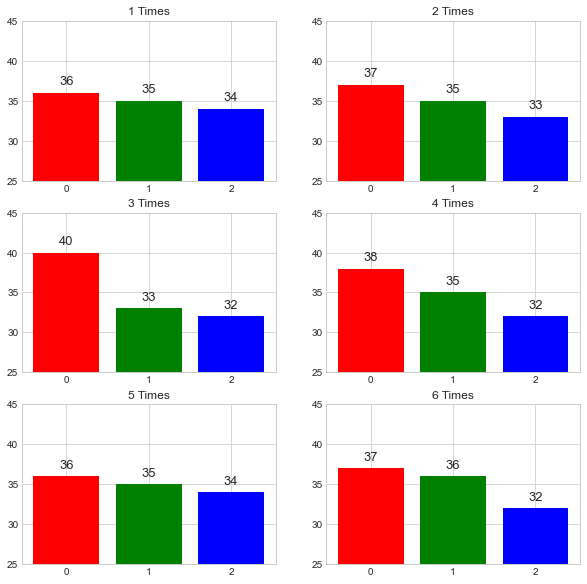

In [4]:
plt.figure(figsize=(10, 10))
for i in range(1, 7):
    # 기본적으로 랜덤하게 데이터를 나눠주며 각각의 레이블에 대한 수는 다르다.
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                    test_size=0.3)
    noraml_train_test_selection = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
    noraml_train_test_selection.columns = [['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','species']]
    
    how_many_label(i, noraml_train_test_selection, 25, 45)

# 교차 검증
- 학습데이터에 대해 과도한 학습을 방지하기 위해 실시
- 데이터의 편중을 막기 위해 별도의 여러 세트로 구성된 학습데이터 세트와 검증 데이터 세트에서 학습과 평가를 수행
- K 폴드 교차 검증과 Stratified K 폴드 교차 검증으로 나뉨

## K 폴드 교차 검증
![image](https://user-images.githubusercontent.com/70187490/128149167-e0aed116-eafb-4730-b3a5-41203fe41a73.png)


In [5]:
from sklearn.model_selection import KFold

features = iris.data
label = iris.target

kfold = KFold(n_splits=5)
cv_accuracy=[]

n_iter=0
for train_index, test_index in kfold.split(features):
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    n_iter += 1
    
    accuracy = np.round(accuracy_score(y_test, pred), 4)
    print('{0}회차 검증 정확도: {1}'.format(n_iter, accuracy))
    cv_accuracy.append(accuracy)
    
    
print('평균 검증 정확도: ', np.mean(cv_accuracy))

1회차 검증 정확도: 1.0
2회차 검증 정확도: 0.9667
3회차 검증 정확도: 0.8667
4회차 검증 정확도: 0.9333
5회차 검증 정확도: 0.7333
평균 검증 정확도:  0.9


레이블 당 몇개씩을 나누는지에 대한 시각화

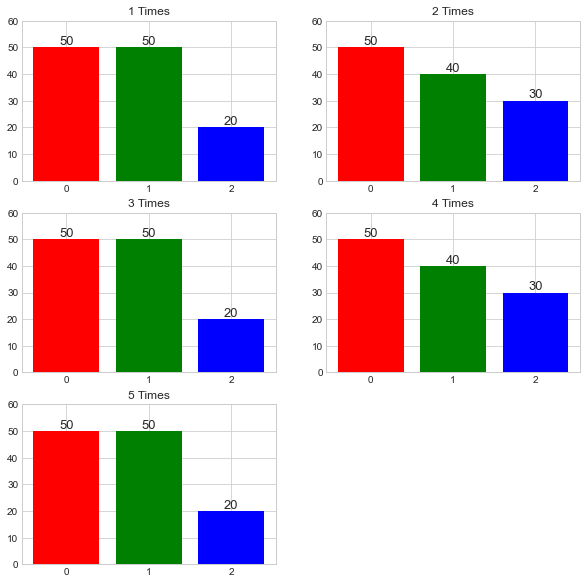

In [6]:
n_iter=0
plt.figure(figsize=(10, 10))
for train_index, test_index in kfold.split(features):
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    n_iter += 1
    
    K_fold_selection = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
    K_fold_selection.columns = [['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','species']]

    how_many_label(n_iter, K_fold_selection, 0, 60)

## Stratified K 폴드
- 불균형한(Imbalanced)분포도를 가진 레이블(결정클래스) 데이터 집합을 위한 K 폴드 방식
- 원본 데이터의 레이블 분포를 먼저 고려한 뒤 이 분포와 동일하게 학습과 검증 데이터 세트를 분배함
- 분류에선 Stratified K폴드로 분할 해야 함
- 회귀에서는 Stratified K 폴드가 지원되지 않음
- 회귀의 결정값은 이산값 형태의 레이블이 아니라 연속된 숫자이기 때문에 결정값별로 분포를 정하는 의미가 없기 때문

**KFold의 문제점**  
- 원본 데이터 집합의 레이블 분포를 학습 및 테스트 세트에 제대로 분배하지 못하는 경우의 문제가 발생  
  -> 이유: shuffle을 하지 않은 채로 앞쪽 부터 학습을 진행하기 때문에 만약 클래스별로 나열되어 있는 경우 학습이 제대로 되지 않음

In [18]:
def how_many_label(label_train, ymin_ticks, ymax_ticks):
    plt.figure(figsize=(4, 3))
    bars = plt.bar(label_train.value_counts().keys(), label_train.value_counts().values, color=['r','g','b'])
    for i, b in enumerate(bars):
        plt.text(b.get_x()+b.get_width()*(1/2), b.get_height()+1, 
                label_train.value_counts().values[i], ha='center',fontsize=13)
        plt.xlim(-0.5, 2.5)
        plt.ylim(35, 55)
        plt.xticks([0, 1, 2 ])
        plt.yticks(np.arange(ymin_ticks, ymax_ticks, 5))
        
    plt.title('{0} Times'.format(n_iter))
    plt.show()

## 교차 검증1
학습 레이블 데이터 분포: 
 1    50
2    50
Name: species, dtype: int64
검증 레이블 데이터 분포: 
 0    50
Name: species, dtype: int64


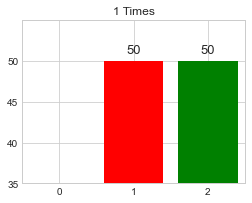

## 교차 검증2
학습 레이블 데이터 분포: 
 0    50
2    50
Name: species, dtype: int64
검증 레이블 데이터 분포: 
 1    50
Name: species, dtype: int64


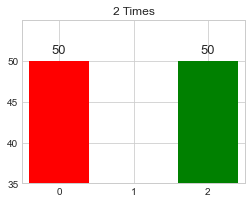

## 교차 검증3
학습 레이블 데이터 분포: 
 0    50
1    50
Name: species, dtype: int64
검증 레이블 데이터 분포: 
 2    50
Name: species, dtype: int64


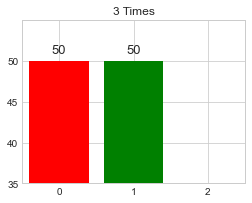

In [19]:
kfold = KFold(n_splits=3)
n_iter = 0
for train_index, test_index in kfold.split(iris_df):
    n_iter += 1
    label_train = iris_df['species'].iloc[train_index]
    label_test = iris_df['species'].iloc[test_index]
    
    print('## 교차 검증{0}'.format(n_iter))
    print('학습 레이블 데이터 분포: \n', label_train.value_counts())
    print('검증 레이블 데이터 분포: \n', label_test.value_counts())
    
    how_many_label(label_train, 35, 55)

Stratified K 폴드는 레이블의 분포를 고르게 만들어 데이터를 나눔

## 교차 검증1
학습 레이블 데이터 분포: 
 2    34
0    33
1    33
Name: species, dtype: int64
검증 레이블 데이터 분포: 
 0    17
1    17
2    16
Name: species, dtype: int64


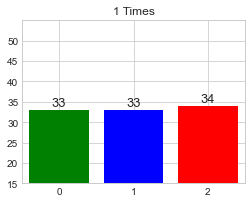

## 교차 검증2
학습 레이블 데이터 분포: 
 1    34
0    33
2    33
Name: species, dtype: int64
검증 레이블 데이터 분포: 
 0    17
2    17
1    16
Name: species, dtype: int64


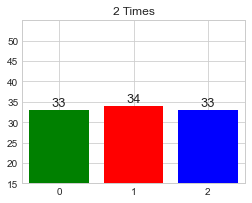

## 교차 검증3
학습 레이블 데이터 분포: 
 0    34
1    33
2    33
Name: species, dtype: int64
검증 레이블 데이터 분포: 
 1    17
2    17
0    16
Name: species, dtype: int64


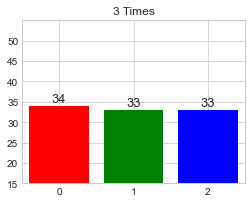

In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)
n_iter = 0

for train_index, test_index in skf.split(iris_df, iris_df['species']):
    n_iter += 1
    label_train= iris_df['species'].iloc[train_index]
    label_test = iris_df['species'].iloc[test_index]
    print('## 교차 검증{0}'.format(n_iter))
    print('학습 레이블 데이터 분포: \n', label_train.value_counts())
    print('검증 레이블 데이터 분포: \n', label_test.value_counts())
    
    how_many_label(label_train, 15, 55)    

**Stratified K 폴드 검증**

In [36]:
dt_clf = DecisionTreeClassifier(random_state=156)

skfold = StratifiedKFold(n_splits=3)
n_iter=0
cv_accuracy=[ ]

# StratifiedKFold의 split() 호출 시 반드시 레이블 데이터 세트도 추가 입력 필요
for train_index, test_index in skfold.split(features, label):
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    
    n_iter += 1
    accuracy = np.round(accuracy_score(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('\n# {0} \n교차 검증 정확도: {1} \n학습 데이터 크기: {2} \n검증 데이터 크기: {3}'
          .format(n_iter, accuracy, train_size, test_size))
    
    cv_accuracy.append(accuracy)

print('\n## 교차 검증별 정확도:', np.round(cv_accuracy, 4))
print('## 평균 검증 정확도:', np.round(np.mean(cv_accuracy), 4))


# 1 
교차 검증 정확도: 0.98 
학습 데이터 크기: 100 
검증 데이터 크기: 50

# 2 
교차 검증 정확도: 0.94 
학습 데이터 크기: 100 
검증 데이터 크기: 50

# 3 
교차 검증 정확도: 0.98 
학습 데이터 크기: 100 
검증 데이터 크기: 50

## 교차 검증별 정확도: [0.98 0.94 0.98]
## 평균 검증 정확도: 0.9667


# cross_val_score

- 학습/테스트 데이터 세트 분리와 교차검증을 한꺼번에 수행해줌
- cross_val_score( ) 내부에서 Estimator를 학습(fit), 예측(predict), 평가(evaluation) 시켜줌
- 내부적으로 StratifiedKFold를 이용함 (회귀는 K 폴드 방식으로 분할)
![image](https://user-images.githubusercontent.com/70187490/128188202-950c2cfc-a1e9-4d5c-8294-d581ab3d5bda.png)


In [43]:
from sklearn.model_selection import cross_val_score, cross_validate

score = cross_val_score(dt_clf,features, label, scoring='accuracy', cv=3)
print('교차 검증별 정확도:', np.round(score, 4))
print('평균 검증 정확도:', np.round(np.mean(score), 4))

교차 검증별 정확도: [0.98 0.94 0.98]
평균 검증 정확도: 0.9667


# GridSearchCV
- 교차 검증과 최적 하이퍼 파라미터 튜닝을 한번에 할 수 있다.
- 데이터 세트를 cross-validation을 위한 학습/테스트 세트로 자동으로 분할한 뒤  
하이퍼파라미터 그리드에 기술된 모든 파라미터를 순차적으로 적용해 최적의 파라미터를 찾을 수 있게 해줌
- 수행시간에 상대적으로 오래 걸림

In [79]:
from sklearn.model_selection import GridSearchCV

iris_data=load_iris()

dtree = DecisionTreeClassifier()

## 파라미터를 딕셔너리 형태로 설정
criterion = ['gini','entropy']
splitter = ['best','random']
max_depth = [10, 50, 100, 150, 200]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto','sqrt','log2']
param_grid = dict(criterion = criterion, splitter = splitter, max_depth = max_depth, 
                  min_samples_leaf = min_samples_leaf, max_features = max_features)

gs = GridSearchCV(estimator=dtree,
                  param_grid=param_grid,
                  cv=10, refit=True)

result = gs.fit(iris_data.data, iris_data.target)
print('최적의 점수: {}'.format(result.best_score_))
print('최적의 파라미터: {}'.format(result.best_params_))

최적의 점수: 0.9733333333333334
최적의 파라미터: {'criterion': 'gini', 'max_depth': 200, 'max_features': 'auto', 'min_samples_leaf': 3, 'splitter': 'best'}


In [81]:
score_df = pd.DataFrame(gs.cv_results_)
score_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 
          'split1_test_score', 'split2_test_score']].sort_values(by='rank_test_score').head(10)

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
124,"{'criterion': 'gini', 'max_depth': 200, 'max_f...",0.973333,1,1.0,0.933333,1.0
111,"{'criterion': 'gini', 'max_depth': 150, 'max_f...",0.966667,2,1.0,1.000000,1.0
10,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.966667,2,1.0,1.000000,1.0
228,"{'criterion': 'entropy', 'max_depth': 100, 'ma...",0.966667,2,1.0,0.933333,1.0
104,"{'criterion': 'gini', 'max_depth': 150, 'max_f...",0.966667,5,1.0,0.933333,1.0
161,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.966667,5,1.0,1.000000,1.0
50,"{'criterion': 'gini', 'max_depth': 50, 'max_fe...",0.966667,5,1.0,0.933333,1.0
164,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.966667,5,1.0,0.933333,1.0
174,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.966667,5,1.0,0.933333,1.0
291,"{'criterion': 'entropy', 'max_depth': 200, 'ma...",0.966667,5,1.0,0.933333,1.0
